# Data setup

In [1]:
import numpy as np
from scipy.optimize import minimize
from functools import partial

# x = np.linspace(0, 100, 1001)
x = np.array([3])

In [2]:
from scipy.stats import norm, multivariate_normal

def sigma_fn(c, w_0=0.5, w_1=7):
    return w_0 ** 2 + (w_1 ** 2) * c

def sigma_deriv_w_0(c, w_0, w_1):
    return 2 * w_0

def sigma_deriv_w_1(c, w_0, w_1):
    return 2 * w_1 * c

num_samples = 10000

c = np.random.rand(num_samples)
sigma_2 = sigma_fn(c)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
y = x + eps

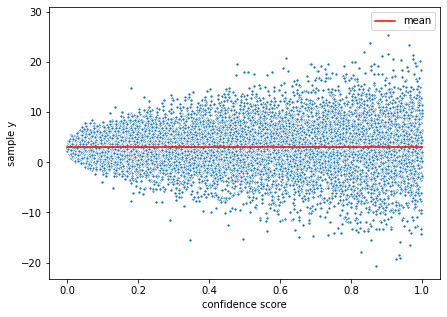

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(7, 5))
sns.scatterplot(c, y, s=10)
plt.xlabel('confidence score')
plt.ylabel('sample y')
plt.plot([0, 1], [y.mean(), y.mean()], 'r', label='mean')
plt.legend(loc='upper right');

In [4]:
y[c < 0.1].std(), y[c > 0.9].std()

(1.654848809932813, 6.794000865222256)

# 1.1: Frequentist approach

In [8]:
def l_deriv_mu(mu, w_0, w_1):
    return ((y - mu) / sigma_fn(c, w_0, w_1)).sum()

def l_deriv_w0(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_deriv_w_0(c, w_0, w_1)
            - (sigma_deriv_w_0(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()

def l_deriv_w1(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_deriv_w_1(c, w_0, w_1)
            - (sigma_deriv_w_1(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()

In [9]:
def l_jac(params):
    mu, w_0, w_1 = params
    return - np.array([l_deriv_mu(mu, w_0, w_1),
                     l_deriv_w0(mu, w_0, w_1),
                     l_deriv_w1(mu, w_0, w_1),
                    ])

In [10]:
def log_fn(params):
    mu = params[0]
    w_0 = params[1]
    w_1 = params[2]
    
    first = (y - mu) ** 2 / sigma_fn(c, w_0=w_0, w_1=w_1)
    second = np.log(sigma_fn(c, w_0=w_0, w_1=w_1) * 2)
    return first.sum() + second.sum()

minimize(log_fn, [3, 0.5, 0.1], jac=l_jac, method='Newton-CG')

     fun: 46247.7859234982
     jac: array([ 1.90765236e-07, -3.58594290e-07,  9.96247174e-08])
 message: 'Optimization terminated successfully.'
    nfev: 33
    nhev: 0
     nit: 29
    njev: 173
  status: 0
 success: True
       x: array([2.99939543, 0.43299187, 7.05760447])

In [11]:
mu_mle, w0_mle, w1_mle = minimize(log_fn, [3, 0.5, 0.1], jac=l_jac, method='Newton-CG').x

In [12]:
mu_mle, w0_mle, w1_mle

(2.9993954306693307, 0.4329918736889297, 7.05760446841141)